# Privacy–Utility Trade-off for Code Completion (HumanEval)

### Imports

In [1]:
# If running on Colab:
!pip install -r ./requirements.txt

import os
import random
import torch
import transformers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

import sys
from pathlib import Path

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 69.0 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=473316e12da381dd0ae24f34c381b1c423dfb793f0400866ff1c385ab08b3473
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge-score


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Utils

In [3]:
from __future__ import annotations

import ast
import builtins
import io
import keyword
import re
import tokenize
from typing import Dict, Set

from rouge_score import rouge_scorer
from rapidfuzz.distance import Levenshtein

_PY_KEYWORDS: Set[str] = set(keyword.kwlist)
_BUILTINS: Set[str] = set(dir(builtins))


# Helpers

def _strip_comments(code: str) -> str:
    """Remove # comments, keep everything else."""
    out_tokens = []
    try:
        tokgen = tokenize.generate_tokens(io.StringIO(code).readline)
        for tok_type, tok_str, *_ in tokgen:
            if tok_type != tokenize.COMMENT:
                out_tokens.append((tok_type, tok_str))
        return tokenize.untokenize(out_tokens)
    except Exception:
        return re.sub(r"#.*", "", code)


def _normalize_docstring(ds: str) -> str:
    """
    Keep only the first sentence of a docstring.
    Removes examples, lists, and extra detail.
    """
    ds = ds.strip()
    # Cut at first example or doctest
    ds = ds.split(">>>")[0]
    # Take first sentence
    match = re.split(r"\.\s+", ds, maxsplit=1)
    return match[0].strip() + "." if match else ds


def _collect_body_names(func: ast.FunctionDef) -> Set[str]:
    """Collect identifiers used inside function body only."""
    names: Set[str] = set()

    class Visitor(ast.NodeVisitor):
        def visit_Name(self, node: ast.Name):
            names.add(node.id)

        def visit_Attribute(self, node: ast.Attribute):
            self.visit(node.value)

    for stmt in func.body:
        Visitor().visit(stmt)

    return names


def _make_name_mapping(used_names: Set[str], mode: str) -> Dict[str, str]:
    mapping: Dict[str, str] = {}
    i = 0

    for name in sorted(used_names):
        if (
            name in _PY_KEYWORDS
            or name in _BUILTINS
            or name.startswith("__")
            or name in {"self", "cls"}
        ):
            continue

        new_name = f"v{i}" if mode == "low" else f"VAR_{i}"
        while new_name in used_names:
            i += 1
            new_name = f"v{i}" if mode == "low" else f"VAR_{i}"

        mapping[name] = new_name
        i += 1

    return mapping


# AST transformers

class _Renamer(ast.NodeTransformer):
    def __init__(self, mapping: Dict[str, str]):
        self.mapping = mapping

    def visit_Name(self, node: ast.Name):
        if node.id in self.mapping:
            return ast.copy_location(
                ast.Name(id=self.mapping[node.id], ctx=node.ctx), node
            )
        return node

    def visit_Attribute(self, node: ast.Attribute):
        node.value = self.visit(node.value)
        return node

    def visit_FunctionDef(self, node: ast.FunctionDef):
        # Preserve API: name, args, returns, decorators
        node.body = [self.visit(stmt) for stmt in node.body]
        return node


class _LiteralMasker(ast.NodeTransformer):
    """Mask string and numeric literals."""

    def visit_Constant(self, node: ast.Constant):
        if isinstance(node.value, str):
            return ast.copy_location(ast.Constant(value="STR"), node)
        if isinstance(node.value, (int, float)):
            return ast.copy_location(ast.Constant(value=0), node)
        return node


class _DocstringNormalizer(ast.NodeTransformer):
    def visit_FunctionDef(self, node: ast.FunctionDef):
        if (
            node.body
            and isinstance(node.body[0], ast.Expr)
            and isinstance(node.body[0].value, ast.Constant)
            and isinstance(node.body[0].value.value, str)
        ):
            node.body[0].value.value = _normalize_docstring(
                node.body[0].value.value
            )
        return node



# Public API

def low_obfuscation(prompt: str) -> str:
    """
    Low obfuscation:
    - rename local variables only
    - preserve signature, types, docstring
    - normalize formatting via AST
    """
    try:
        tree = ast.parse(prompt)
        for node in tree.body:
            if isinstance(node, ast.FunctionDef):
                names = _collect_body_names(node)
                mapping = _make_name_mapping(names, mode="low")
                _Renamer(mapping).visit(node)
        ast.fix_missing_locations(tree)
        return ast.unparse(tree)
    except Exception:
        return prompt


def high_obfuscation(prompt: str) -> str:
    """
    High obfuscation:
    - strip # comments
    - normalize docstring
    - rename locals aggressively
    - mask string & numeric literals
    """
    try:
        stripped = _strip_comments(prompt)
        tree = ast.parse(stripped)

        _DocstringNormalizer().visit(tree)
        _LiteralMasker().visit(tree)

        for node in tree.body:
            if isinstance(node, ast.FunctionDef):
                names = _collect_body_names(node)
                mapping = _make_name_mapping(names, mode="high")
                _Renamer(mapping).visit(node)

        ast.fix_missing_locations(tree)
        return ast.unparse(tree)
    except Exception:
        return prompt


# Metrics

def privacy_score(prompt_variant: str, prompt_original: str) -> float:
    if not prompt_original:
        return 0.0
    dist = Levenshtein.distance(prompt_variant, prompt_original)
    return dist / max(len(prompt_original), len(prompt_variant), 1)


_scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=False)

def utility_score_rougeL(completion: str, canonical_solution: str) -> float:
    scores = _scorer.score(canonical_solution, completion)
    return float(scores["rougeL"].fmeasure)


### Dataset Loading

In [4]:
# 1) Load dataset (first 20 examples from test split)

ds = load_dataset("openai/openai_humaneval", split="test")
ds20 = ds.select(range(20))

# Quick peek
ds20[0].keys(), ds20[0]["task_id"]


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

openai_humaneval/test-00000-of-00001.par(…):   0%|          | 0.00/83.9k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/164 [00:00<?, ? examples/s]

(dict_keys(['task_id', 'prompt', 'canonical_solution', 'test', 'entry_point']),
 'HumanEval/0')

In [5]:
# 2) Prepare prompt variants

rows = []
for ex in ds20:
    original = ex["prompt"]
    low = low_obfuscation(original)
    high = high_obfuscation(original)
    rows.append({
        "task_id": ex["task_id"],
        "prompt_original": original,
        "prompt_low": low,
        "prompt_high": high,
        "canonical_solution": ex["canonical_solution"],
    })

df = pd.DataFrame(rows)
df.head()


,task_id,prompt_original,prompt_low,prompt_high,canonical_solution
0,HumanEval/0,from typing import List\n\n\ndef has_close_ele...,from typing import List\n\ndef has_close_eleme...,from typing import List\n\ndef has_close_eleme...,"for idx, elem in enumerate(numbers):\n ..."
1,HumanEval/1,from typing import List\n\n\ndef separate_pare...,from typing import List\n\ndef separate_paren_...,from typing import List\n\ndef separate_paren_...,result = []\n current_string = []\n ...
2,HumanEval/2,\n\ndef truncate_number(number: float) -> floa...,def truncate_number(number: float) -> float:\n...,def truncate_number(number: float) -> float:\n...,return number % 1.0\n
3,HumanEval/3,from typing import List\n\n\ndef below_zero(op...,from typing import List\n\ndef below_zero(oper...,from typing import List\n\ndef below_zero(oper...,balance = 0\n\n for op in operations:\n...
4,HumanEval/4,from typing import List\n\n\ndef mean_absolute...,from typing import List\n\ndef mean_absolute_d...,from typing import List\n\ndef mean_absolute_d...,mean = sum(numbers) / len(numbers)\n re...


### Model Loadning

In [6]:
# 3) Load model

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

model_name = os.environ.get("MODEL_NAME", "Maincode/Maincoder-1B")

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    trust_remote_code=True,
).to(device)
tok = AutoTokenizer.from_pretrained(
    model_name,
    trust_remote_code=True,
)

device, model_name


config.json:   0%|          | 0.00/918 [00:00<?, ?B/s]

configuration_maincoder.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/Maincode/Maincoder-1B:
- configuration_maincoder.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modelling_maincoder.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/Maincode/Maincoder-1B:
- modelling_maincoder.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/2.05G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

('cuda', 'Maincode/Maincoder-1B')

In [9]:
def generate_completion(prompt: str,
                        max_new_tokens: int = 128,
                        temperature: float = 0.8,
                        top_p: float = 0.95) -> str:
    """Single sampled completion."""
    inputs = tok(prompt, return_tensors="pt").to(model.device)
    out = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        top_p=top_p,
        temperature=temperature,
        do_sample=True
    )
    text = tok.decode(out[0], skip_special_tokens=True)

    return text

# Sanity check (first example, original prompt)
print(df.loc[0, "task_id"])
print("____COMPLITION____")
print(generate_completion(df.loc[0, "prompt_original"]))
print("____SOL____")
print(df.loc[0, "canonical_solution"])

HumanEval/0
____COMPLITION____
from typing import List


def has_close_elements(numbers: List[float], threshold: float) -> bool:
    """ Check if in given list of numbers, are any two numbers closer to each other than
    given threshold.
    >>> has_close_elements([1.0, 2.0, 3.0], 0.5)
    False
    >>> has_close_elements([1.0, 2.8, 3.0, 4.0, 5.0, 2.0], 0.3)
    True
    """
    sorted_nums = sorted(numbers)
    for i in range(len(sorted_nums) - 1):
        if sorted_nums[i + 1] - sorted_nums[i] < threshold:
            return True
    return False

____SOL____
    for idx, elem in enumerate(numbers):
        for idx2, elem2 in enumerate(numbers):
            if idx != idx2:
                distance = abs(elem - elem2)
                if distance < threshold:
                    return True

    return False



### Generation of Complitions

In [10]:
# 4) Generate 60 completions total

outputs = []
for i, row in tqdm(df.iterrows(), total=len(df)):
    for condition, prompt_col in [("original", "prompt_original"),
                                  ("low", "prompt_low"),
                                  ("high", "prompt_high")]:
        prompt = row[prompt_col]
        comp = generate_completion(prompt)

        outputs.append({
            "task_id": row["task_id"],
            "condition": condition,
            "prompt_used": prompt,
            "prompt_original": row["prompt_original"],
            "canonical_solution": row["canonical_solution"],
            "completion": comp,
        })

out_df = pd.DataFrame(outputs)
out_df.head()


  0%|          | 0/20 [00:00<?, ?it/s]

,task_id,condition,prompt_used,prompt_original,canonical_solution,completion
0,HumanEval/0,original,from typing import List\n\n\ndef has_close_ele...,from typing import List\n\n\ndef has_close_ele...,"for idx, elem in enumerate(numbers):\n ...",from typing import List\n\n\ndef has_close_ele...
1,HumanEval/0,low,from typing import List\n\ndef has_close_eleme...,from typing import List\n\n\ndef has_close_ele...,"for idx, elem in enumerate(numbers):\n ...",from typing import List\n\ndef has_close_eleme...
2,HumanEval/0,high,from typing import List\n\ndef has_close_eleme...,from typing import List\n\n\ndef has_close_ele...,"for idx, elem in enumerate(numbers):\n ...",from typing import List\n\ndef has_close_eleme...
3,HumanEval/1,original,from typing import List\n\n\ndef separate_pare...,from typing import List\n\n\ndef separate_pare...,result = []\n current_string = []\n ...,from typing import List\n\n\ndef separate_pare...
4,HumanEval/1,low,from typing import List\n\ndef separate_paren_...,from typing import List\n\n\ndef separate_pare...,result = []\n current_string = []\n ...,from typing import List\n\ndef separate_paren_...


In [11]:
print("-----Original Prompt-----")
print(out_df.loc[4, "prompt_original"])
print("-----Prompt Used-----")
print(out_df.loc[4, "prompt_used"])
print("-----Canonical Solution-----")
print(out_df.loc[4, "canonical_solution"])
print("-----Completion-----")
print(out_df.loc[4, "completion"])

-----Original Prompt-----
from typing import List


def separate_paren_groups(paren_string: str) -> List[str]:
    """ Input to this function is a string containing multiple groups of nested parentheses. Your goal is to
    separate those group into separate strings and return the list of those.
    Separate groups are balanced (each open brace is properly closed) and not nested within each other
    Ignore any spaces in the input string.
    >>> separate_paren_groups('( ) (( )) (( )( ))')
    ['()', '(())', '(()())']
    """

-----Prompt Used-----
from typing import List

def separate_paren_groups(paren_string: str) -> List[str]:
    """ Input to this function is a string containing multiple groups of nested parentheses. Your goal is to
    separate those group into separate strings and return the list of those.
    Separate groups are balanced (each open brace is properly closed) and not nested within each other
    Ignore any spaces in the input string.
    >>> separate_paren_groups

In [12]:
# 5) Score utility + privacy

out_df["privacy"] = out_df.apply(lambda r: privacy_score(r["prompt_used"], r["prompt_original"]), axis=1)
out_df["utility"] = out_df.apply(lambda r: utility_score_rougeL(r["completion"], r["canonical_solution"]), axis=1)

out_df.groupby("condition")[["privacy","utility"]].mean()


,privacy,utility
condition,,
high,0.750310,0.198933
low,0.008304,0.207656
original,0.000000,0.250465


### Analysis

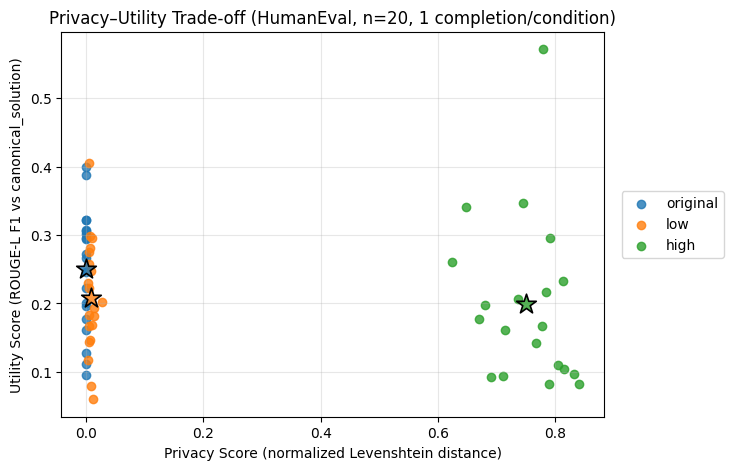

In [15]:
plt.figure(figsize=(7,5))

for cond in ["original", "low", "high"]:
    sub = out_df[out_df["condition"] == cond]

    sc = plt.scatter(
        sub["privacy"],
        sub["utility"],
        label=cond,
        alpha=0.8
    )

    mean_priv = sub["privacy"].mean()
    mean_util = sub["utility"].mean()

    plt.scatter(
        mean_priv,
        mean_util,
        marker="*",
        s=220,
        edgecolor="black",
        linewidth=1.2,
        color=sc.get_facecolor()[0],
        zorder=6
    )

plt.xlabel("Privacy Score (normalized Levenshtein distance)")
plt.ylabel("Utility Score (ROUGE-L F1 vs canonical_solution)")
plt.title("Privacy–Utility Trade-off (HumanEval, n=20, 1 completion/condition)")
plt.legend(
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=True
)
plt.grid(True, alpha=0.3)
plt.show()


## Brief analysis (draft)

- The plot shows a clear difference in privacy between the conditions. Original and low-obfuscation prompts are grouped close to zero normalized Levenshtein distance, while high obfuscation results in much larger distances. This means the obfuscation functions make the prompts more different from each other.

    On the other hand, utility, measured by ROUGE-L F1 compared to the main solution, stays fairly low in all conditions. Original prompts have the highest average utility. Low obfuscation lowers performance a bit, and high obfuscation causes an even bigger drop, as shown by the star markers. This shows a trade-off between privacy and utility: stronger obfuscation gives more privacy but makes it harder for the model to produce outputs similar to the reference solution.


- The privacy score is defined as a normalized edit distance:


    $Privacy(\hat p,p)=\frac{d_{Lev}(\hat p,p)}{max(|\hat \space p|,|p|)}$

    so any systematic modification of the prompt (renaming variables, masking literals, stripping comments) increases $d_{Lev}$​ and therefore raises the privacy score almost monotonically. This explains the strong right shift of the high obfuscation points.

    Utility is measured using ROUGE-L:

    $Utility(y,\ hat y)=ROUGEL_{F1}(y,\hat y)$

    which quantifies longest common subsequence overlap between the generated completion $y$ and a single canonical solution $\hat y$. 
    
    Let: 
    - $y=(y_1,…,y_m)$ be the generated completion
    - $ \hat y=( \hat y_1 ,…, \hat y_n)$ be the canonical solution
    Define:
    $LCS(y, \hat y)=$ length of the longest subsequence common to both $y$ and $\hat y$.From this, ROUGE-L defines precision and recall as:
    $P_{LCS}=\frac{LCS(y,\hat y)}{|y|} , $R_{LCS}=\frac{LCS(y, \hat y)}{|y|}$.

    The reported ROUGE-L F1 score is then: $ROUGE-L_{F1}(y,\ hat y) = \frac{2 P_{LCS}R_{LCS}​}{P_{LCS} + R_{LCS}}$ .For code, this metric is inherently strict: many functionally correct implementations can differ substantially in variable names, control flow, or ordering of operations, yielding low lexical overlap.

    Moreover, the relatively small completion model used here produces partially correct but lexically diverse solutions, which further reduces ROUGE-L scores even for original prompts. As a result, absolute utility values remain modest, and the observed degradation under obfuscation reflects both (i) information loss from the prompt and (ii) limitations of the model and metric, rather than obfuscation alone